# Linear Trends in Gridded Data

This is a simple example that shows how to detect linear trends in a gridded dataset. 

The example data is the HadCRUT data (`HadCRUT.4.6.0.0.median.nc`), which was obtained from https://crudata.uea.ac.uk/cru/data/temperature/. 

The function `get_trend` takes and input file path, variable name, and optionally a method (explained later). The dataset is opened, and an annual mean is taken. The trend is obtained by fitting a line through the data at each spatial point using the `polyfit` method. The only tricky thing here is that the `get_trend` function returns the coefficients. The slope is given by the first one, while the second one is the constant term (i.e., in $y = mx + b$ )

To check the goodness of fit, we can look at the $r^2$ value using the `get_rsquare` function. To check for trends that are statistically significant from zero, we use a 2-sided t-test from SciPy's stats package. 

In [1]:
import numpy as np
import xarray as xr
import geocat.comp as gc
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy import stats




In [104]:

def get_trend(ifil, v, method='xarray', deg=1):
    ds = xr.open_dataset(ifil, decode_times=False)
    if 'time_bnds' in ds:
        correct_time = ds['time_bnds'].mean(dim='nbnd')
        correct_time.attrs = ds['time'].attrs
        ds = ds.assign_coords({"time":correct_time})
    ds = xr.decode_cf(ds)
    if 'longitude' in ds.dims:
        ds = ds.rename({'longitude':'lon'})
    if 'latitude' in ds.dims:
        ds = ds.rename({'latitude':'lat'})
    X = ds[v]
    X = X.groupby('time.year').mean(dim='time')
    X = X.rename({'year':'time'})
    print(f"X coords: {X.coords}")
    print(f"X shape: {X.shape}")
    print(f"X min: {X.min().item()}, max: {X.max().item()}")
    # yearfrac = X.time.dt.year + X.time.dt.month/12
    yearfrac = X.time
    print(f"Time shape: {yearfrac.shape}")
    if method == 'geocat':
        coefs = gc.polynomial.ndpolyfit(yearfrac, X.values, deg=deg, axis=0, meta=False, full=False)
    elif method == 'xarray':
        coefs = X.polyfit(dim='time', deg=deg, skipna=True)  # polyfit_coefficients[degree, lat, lon]
    else:
        print(f"ERROR method = {method}")
    return coefs

        
def get_rsquare(dataOrig, coefficients):
    # print(y_fitted)
    # exit
    # # r**2
    yhat = xr.polyval(dataOrig.time, coefficients)
    ybar = dataOrig.mean(dim='time')
    ssreg = ((yhat - ybar)**2).sum(dim='time')
    sstot = ((X - ybar)**2).sum(dim='time')
    rsquared = 1 - (ssreg / sstot)
    return rsquared


def get_pvalue(dataOrig, coefficients):
    yhat = xr.polyval(dataOrig.time, coefficients)
    tt, pval = stats.ttest_ind(dataOrig, yhat['polyfit_coefficients'], axis=0, nan_policy='omit')
    return xr.DataArray(pval, dims=("lat","lon"), coords={"lat":dataOrig.lat, "lon":dataOrig.lon})


def map_trend(data, ofil):
    print(f"Trend min: {data.min().item()}, max: {data.max().item()}")
    fig, ax = plt.subplots(subplot_kw={"projection":ccrs.Mollweide()})
    lons, lats = np.meshgrid(data.lon, data.lat)
    ax.coastlines()
    ax.set_global()
    # img = ax.pcolormesh(lons, lats, data.values, cmap='plasma_r', rasterized=False)
    img = ax.contourf(lons, lats, data.values, cmap='plasma_r')
    fig.colorbar(img)
    plt.show()
    fig.savefig(ofil, bbox_inches='tight', dpi=200)


def map_rsquared(data, ofil):
    print(f"shape of data is {data.shape}")
    fig, ax = plt.subplots(subplot_kw={"projection":ccrs.Mollweide()})
    lons, lats = np.meshgrid(data.lon, data.lat)
    img = ax.pcolormesh(lons, lats, data, cmap='plasma_r', norm=mpl.colors.Normalize(vmin=0,vmax=1), rasterized=True, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_global()
    fig.colorbar(img)
    fig.savefig(ofil, bbox_inches='tight', dpi=200)
    



In [69]:
#
# Data
#
input_file = "/Users/brianpm/Dropbox/Data/HadCRUT/HadCRUT.4.6.0.0.median.nc"

In [70]:
#
# get the trend 
#
tr = get_trend(input_file, "temperature_anomaly", method='xarray')

tr  # Dataset --> tr['polyfit_coefficients'] is what to use. 
    # tr['polyfit_coefficients'] will be (degree: 2, lat: 36, lon: 72) for the HadCRUT data

X coords: Coordinates:
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2015 2016 2017 2018 2019
X shape: (170, 36, 72)
X min: -11.148754119873047, max: 9.656693458557129
Time shape: (170,)


/Users/brianpm/miniconda3/envs/w/lib/python3.9/site-packages/xarray/core/nputils.py:166: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


<xarray.Dataset>
Dimensions:               (degree: 2, lat: 36, lon: 72)
Coordinates:
  * degree                (degree) int64 1 0
  * lat                   (lat) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * lon                   (lon) float64 -177.5 -172.5 -167.5 ... 172.5 177.5
Data variables:
    polyfit_coefficients  (degree, lat, lon) float64 nan nan ... 20.26 -37.32

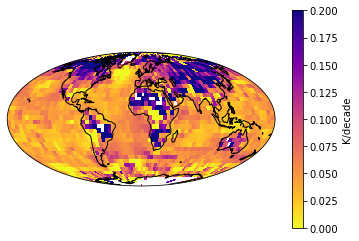

In [83]:
#
# Visualize the trend
#
slope = tr['polyfit_coefficients'][0,:,:]
fig, ax = plt.subplots(subplot_kw={"projection":ccrs.Mollweide()})
lons, lats = np.meshgrid(slope.lon, slope.lat)
img = ax.pcolormesh(lons, lats, 10*slope, cmap='plasma_r', norm=mpl.colors.Normalize(vmin=0,vmax=0.2), rasterized=True, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
fig.colorbar(img, label='K/decade')

## global mean time series

Just to show very clearly how this works, we can re-load the data and get the global mean time series and repeat the process of getting the trend.

In [77]:
dsraw = xr.open_dataset(input_file)  # data set from HadCRUT
# rename coordinates
if 'longitude' in dsraw.dims:
    dsraw = dsraw.rename({'longitude':'lon'})
if 'latitude' in dsraw.dims:
    dsraw = dsraw.rename({'latitude':'lat'})
    
Xraw = dsraw['temperature_anomaly']
# Annual means:
Xraw = Xraw.groupby('time.year').mean(dim='time') 
Xraw = Xraw.rename({'year':'time'})


print(f"X coords: {Xraw.coords}")
print(f"X shape: {Xraw.shape}")
print(f"X min: {Xraw.min().item()}, max: {Xraw.max().item()}")

X coords: Coordinates:
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2015 2016 2017 2018 2019
X shape: (170, 36, 72)
X min: -11.148754119873047, max: 9.656693458557129


In [79]:
# apply area weighting
Xw = Xraw.weighted(np.cos(np.radians(Xraw.lat)))

# global mean:
glb =  Xw.mean(dim=("lat","lon"))

# gets the coefficients for the linear fit at each grid point
gtrendfit = glb.polyfit(dim='time', deg=1, skipna=True)  # polyfit_coefficients[degree, lat, lon]

# use polyval to provide the estimated time series (from the linear model)
gfit = xr.polyval(glb.time, gtrendfit)

# directly use the coefficents to make the estimate
hfit = gtrendfit['polyfit_coefficients'][0]*glb.time + gtrendfit['polyfit_coefficients'][1]

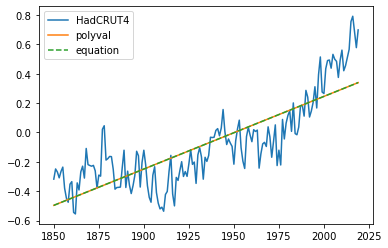

In [81]:
#
# visualize the actual time series along with the two fits (they're the same)
#
fig, ax = plt.subplots()
ax.plot(glb.time, glb, label='HadCRUT4')
ax.plot(glb.time, gfit['polyfit_coefficients'], label='polyval')
ax.plot(glb.time, hfit, linestyle='dashed', label='equation')
ax.legend()

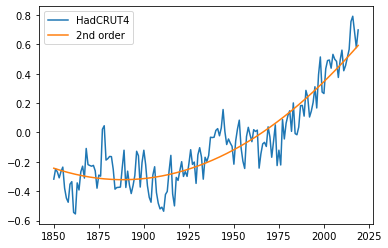

In [82]:
#
# See if a 2nd order polynomial does better
#
# gets the coefficients for the linear fit at each grid point
gtrendfit = glb.polyfit(dim='time', deg=2, skipna=True)  # polyfit_coefficients[degree, lat, lon]

# use polyval to provide the estimated time series (from the linear model)
gfit = xr.polyval(glb.time, gtrendfit)

fig, ax = plt.subplots()
ax.plot(glb.time, glb, label='HadCRUT4')
ax.plot(glb.time, gfit['polyfit_coefficients'], label='2nd order')
ax.legend()

## Significance test

Return to the global data and get the p-values.

In [90]:
pval = get_pvalue(Xraw, tr)  # pass the coefficients `tr`, `get_pvalue` will use `polyval` for the comparison.


/Users/brianpm/miniconda3/envs/w/lib/python3.9/site-packages/scipy/stats/mstats_basic.py:1077: RuntimeWarning: divide by zero encountered in true_divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!


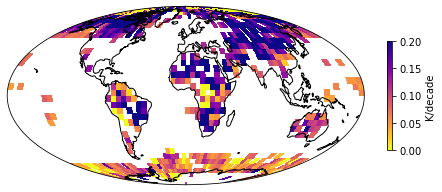

In [95]:
#
# Visualize only significant trends
#
sigtrend = np.where( pval < 0.05, 10.*slope, np.nan)  # multiply by 10 to get degrees / decade
sigtrend = xr.DataArray(sigtrend, dims=("lat","lon"), coords={"lat":Xraw.lat, "lon":Xraw.lon})

fig, ax = plt.subplots(figsize=(8,4), subplot_kw={"projection":ccrs.Mollweide()})
lons, lats = np.meshgrid(sigtrend.lon, sigtrend.lat)
img = ax.pcolormesh(lons, lats, sigtrend, cmap='plasma_r', norm=mpl.colors.Normalize(vmin=0,vmax=0.2), rasterized=True, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
fig.colorbar(img, label='K/decade', shrink=0.5)

In [96]:
# What about if we used a 2nd degree polynomial?  
# easy enough to do the fit, but then what is the "trend"? Just plot delta T? 

X coords: Coordinates:
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2015 2016 2017 2018 2019
X shape: (170, 36, 72)
X min: -11.148754119873047, max: 9.656693458557129
Time shape: (170,)
<xarray.DataArray 'polyfit_coefficients' (time: 170, lat: 36, lon: 72)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [ 3.88083772e-01,  2.64665066e+00,  4.48580699e+00, ...,
                     nan,  2.15511035e+00,  4.73169099e-01],
        ...,
        [-9.61847892e+00,  8.13711104e+00, -1.42075049e+01, ...,
                     nan, -2.98512650e+01, -2.70384278e+01],
        [-2.76181044e+01, -7.48188236e+01, -2.49530512e+0

/Users/brianpm/miniconda3/envs/w/lib/python3.9/site-packages/xarray/core/nputils.py:166: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/Users/brianpm/miniconda3/envs/w/lib/python3.9/site-packages/scipy/stats/mstats_basic.py:1077: RuntimeWarning: divide by zero encountered in true_divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!


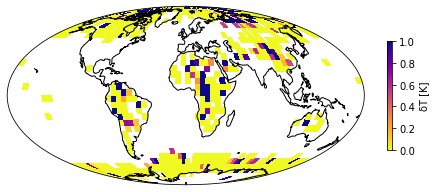

In [122]:
tr = get_trend(input_file, "temperature_anomaly", method='xarray', deg=2)
fit = xr.polyval(Xraw.time, tr)['polyfit_coefficients']
pval = get_pvalue(Xraw, tr) 
#
# Visualize only significant trends
#
sigtrend = fit.where(pval < 0.05)

print(sigtrend)

fig, ax = plt.subplots(figsize=(8,4), subplot_kw={"projection":ccrs.Mollweide()})
lons, lats = np.meshgrid(sigtrend.lon, sigtrend.lat)
img = ax.pcolormesh(lons, lats, sigtrend.sel(time=slice(1900,1920)).mean('time') - sigtrend.sel(time=slice(2000,2020)).mean('time'), cmap='plasma_r', 
                    norm=mpl.colors.Normalize(vmin=0,vmax=1.), rasterized=True, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
fig.colorbar(img, label='δT [K]', shrink=0.5)